# About this notebook

Image blending:
- Linear blending
- Linear blending + gaussian filter
- Linear blending + cv inpaint
- Overlaying + HuggingFace inpainting

# Environment

In [3]:
import os

import cv2 as cv
import matplotlib.pylab as plt
import numpy as np

# Parameters

In [11]:
DATA_DIR = "../../data/test"

# Blending parameters
alpha = 0.6
beta = 1 - alpha

# Load example

In [5]:
patch = cv.imread(os.path.join(DATA_DIR, "img1.jpg"))
background = cv.imread(os.path.join(DATA_DIR, 'img2.jpg'), cv.IMREAD_COLOR)
background = cv.cvtColor(background, cv.COLOR_RGB2BGR)

In [7]:
# Make sure the patch is small in comparison to the background image
bg_y, bg_x, _ = background.shape
scaling = 0.4
patch = cv.resize(patch, (int(bg_x * scaling), int(bg_y * scaling)))
p_x, p_y, _ = patch.shape

In [8]:
# Select an area in the background where we want to add the patch
x, y = 500, 600
bg_patch = background[x:x+p_x, y:y+p_y, :]

In [9]:
assert bg_patch.shape == patch.shape

# Linear blending

In [12]:
# Blend patch and subset of background
dst = cv.addWeighted(patch, alpha, bg_patch, beta, 0)

In [13]:
# Add blended images pack into the background
background_edited = background.copy()
background_edited[x:x+p_x, y:y+p_y, :] = dst

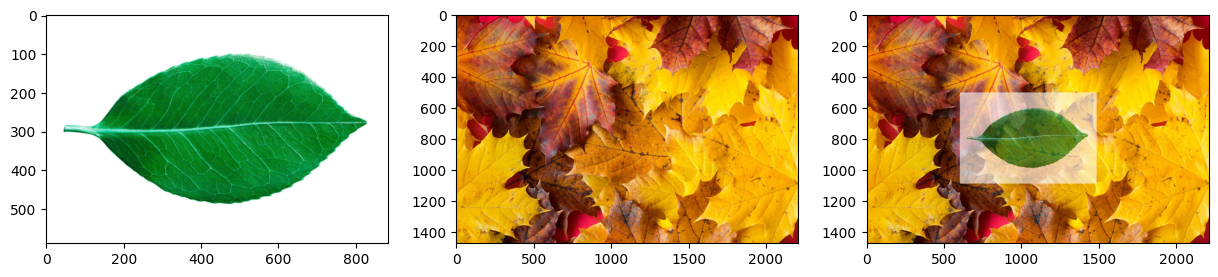

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(patch)
axes[1].imshow(background)
axes[2].imshow(background_edited)

# Linear blending + Gaussian blur

TODO: Blur on edges of added patch once it has been added to the background

In [15]:
dst_blurred = cv.GaussianBlur(
    dst,
    (0,0),
    sigmaX=3,
    sigmaY=3,
    borderType=cv.BORDER_DEFAULT
)

In [16]:
# Add blended images pack into the background
background_edited_blurred = background.copy()
background_edited_blurred[x:x+p_x, y:y+p_y, :] = dst_blurred

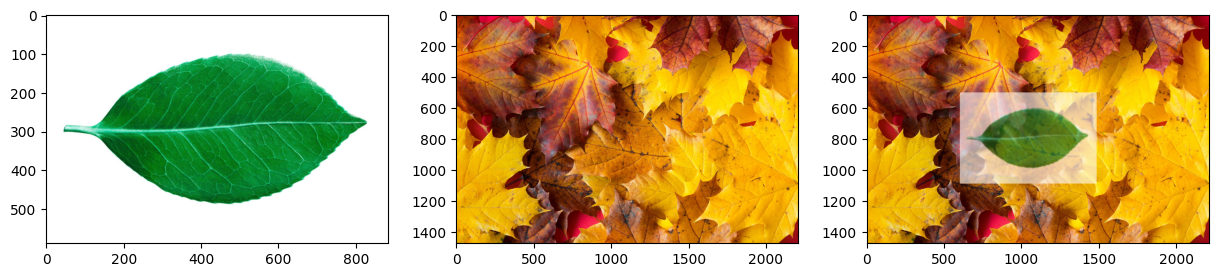

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(patch)
axes[1].imshow(background)
axes[2].imshow(background_edited_blurred)

# Linear blending + Inpainting

In [18]:
# Mask is essentially the border around the patch
border = 100  # in pixel
mask = np.zeros((p_x, p_y))
mask[:border, :] = 1
mask[-border:, :] = 1
mask[:, -border:] = 1
mask[:, :border] = 1

tmp = np.zeros((bg_y, bg_x))
tmp[x:x+p_x, y:y+p_y] = mask
mask = tmp

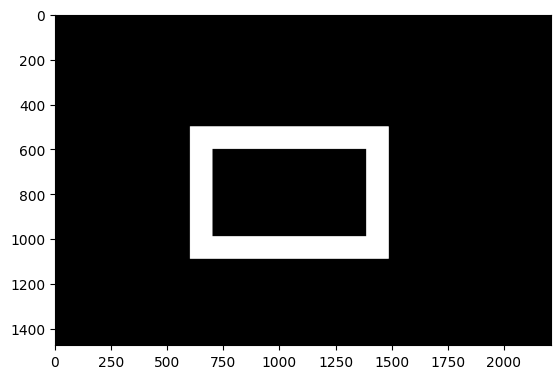

In [19]:
plt.imshow(mask, vmin=0, vmax=1, cmap="Greys_r");

In [20]:
background_edited_inpaint = cv.inpaint(background_edited, mask.astype(np.uint8), 3, cv.INPAINT_TELEA)

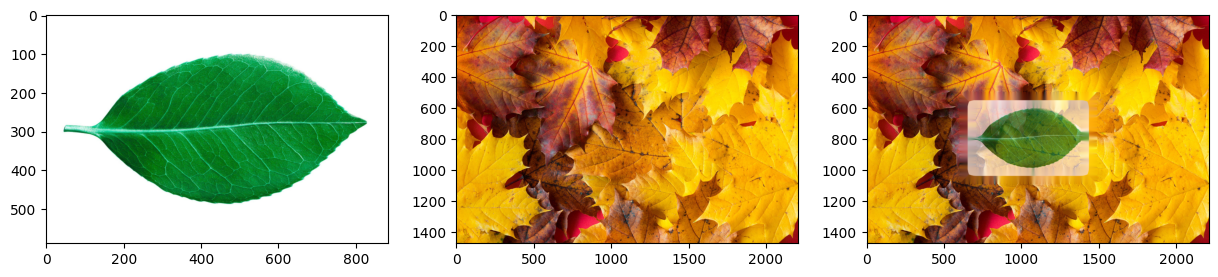

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(patch)
axes[1].imshow(background)
axes[2].imshow(background_edited_inpaint)

# Huggingface inpainting

In [24]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

In [30]:
torch.cuda.is_available()

True

In [28]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    # torch_dtype depends on CPU (float32) vs GPU (float16)
    # https://stackoverflow.com/questions/75641074/i-run-stable-diffusion-its-wrong-runtimeerror-layernormkernelimpl-not-implem
    torch_dtype=torch.float16,
).to("cuda")
prompt = "Perform content aware filling to the mask"
# Image and mask_image should be PIL images.
# The mask structure is white for in-painting and black for keeping as is
image = pipe(
    prompt=prompt, 
    image=Image.fromarray(background_edited), 
    mask_image=Image.fromarray(mask)
).images[0]
image.save(os.path.join(DATA_DIR, "output_huggingface.jpg"))


/home/azureuser/miniconda3/envs/hackathon/lib/python3.11/site-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
safety_checker/model.safetensors not found
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...:  29%|██▊    